# Eigenvalue Problem

Eigenvalue problem blabla

Unfortunately, we found tensorflow objects (such as tensorflow functions) hard to reuse. There is therefore much repetitive code in the code cells below. This notebook is organized such that each code cell have all the necessary code, except imports, to solve a particular problem. To better distinguish what problem a particular code cell solves, we have added headers and a small discussion before and after the code that explains the problem at hand. 

### Configure notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Import code from src
sys.path.insert(0, '../src/')
from tools import fig_path

tf.keras.backend.set_floatx("float64")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)

## FFNN Benchmark Problem

Step: 1, Loss: 1.2770721346990614
Step: 100, Loss: 0.13565214997579497
Step: 200, Loss: 0.04199647585450178
Step: 300, Loss: 0.023209714150359436
Step: 400, Loss: 0.013092356785413612
Step: 500, Loss: 0.010640508899773514
Step: 600, Loss: 0.003952909534331961
Step: 700, Loss: 0.0019266454646665301
Step: 800, Loss: 0.002934178533324888
Step: 900, Loss: 0.005554600359764925
Step: 1000, Loss: 0.0003804426886493388
Step: 1100, Loss: 0.00017570805611972687
Step: 1200, Loss: 0.002008596970728493
Step: 1300, Loss: 0.0001812207837729587
Step: 1400, Loss: 8.379975233079569e-05
Step: 1500, Loss: 0.0019742825027715583
Step: 1600, Loss: 4.782022263943694e-05
Step: 1700, Loss: 0.0015147606807516417
Step: 1800, Loss: 0.0010111974906577947
Step: 1900, Loss: 7.996037658441941e-05
Step: 2000, Loss: 0.00010105130523549834



A = [[3. 2. 4.]
 [2. 0. 2.]
 [4. 2. 3.]]
x0 = [1 0 0]
Eigvals Numpy: [-1.  8. -1.]
Max Eigval Numpy 8.0
Final Rayleigh Quotient Euler 7.999999939924338
Final Rayleigh Quotient FFNN 7.9999972079629735


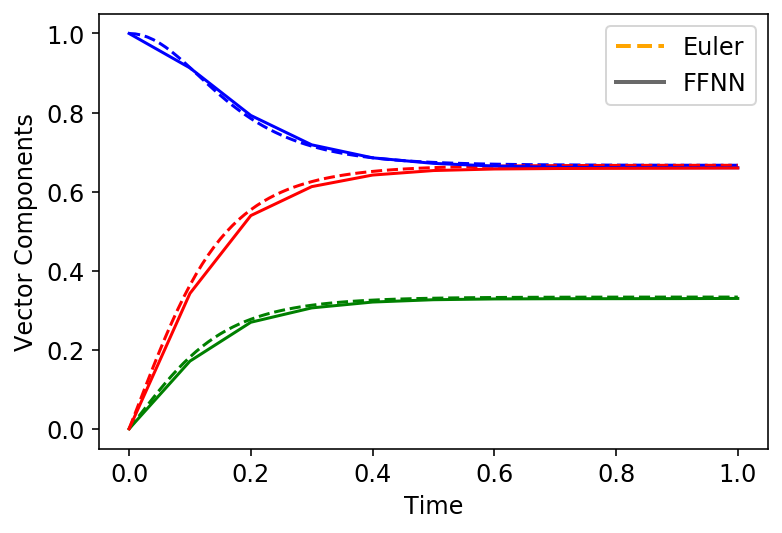

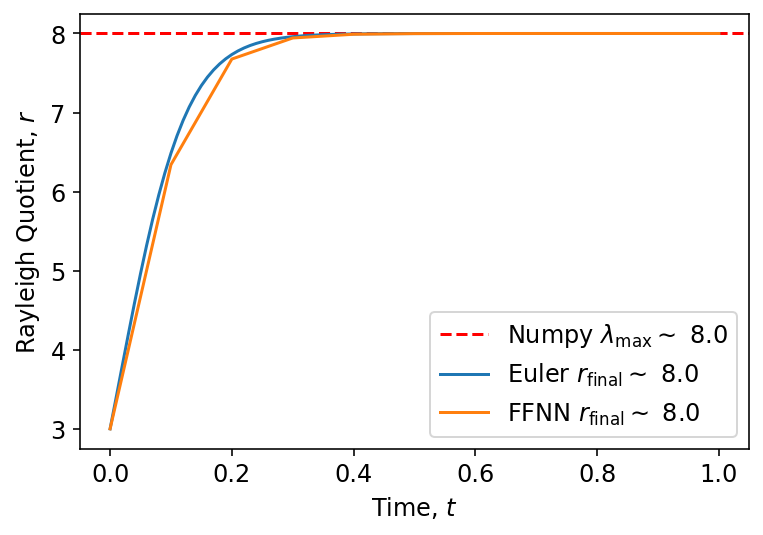

In [17]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
                               x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 101   # number of time points
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
x0 = np.array([1, 0, 0])
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
custom_lines = [Line2D([0], [0], color='orange', ls='--', lw=2),
                Line2D([0], [0], color='dimgrey', lw=2)]
ax0.plot(t, x_euler[:, 0], color='b', ls='--')
ax0.plot(t, x_euler[:, 1], color='g', ls='--')
ax0.plot(t, x_euler[:, 2], color='r', ls='--')
ax0.plot(t_tf, g[:, 0], color='b')
ax0.plot(t_tf, g[:, 1], color='g')
ax0.plot(t_tf, g[:, 2], color='r')
ax0.set_ylabel('Vector Components')
ax0.set_xlabel('Time')
ax0.legend(custom_lines, ['Euler', 'FFNN'])
fig0.savefig(fig_path("eigvec_comp_benchrun1.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_benchrun1.pdf"), bbox_inches='tight')
plt.show()

## Benchmark problem

Step: 1, Loss: 1.4253581597021954
Step: 100, Loss: 0.21476604767755114
Step: 200, Loss: 0.03977562486538849
Step: 300, Loss: 0.015857957199155583
Step: 400, Loss: 0.00975734487679856
Step: 500, Loss: 0.005421397775712499
Step: 600, Loss: 0.0035816662752097537
Step: 700, Loss: 0.0022619799827642314
Step: 800, Loss: 0.0014662280281849314
Step: 900, Loss: 0.0005523036464092012
Step: 1000, Loss: 0.00025258369232811516
Step: 1100, Loss: 0.0012953960538167166
Step: 1200, Loss: 0.00034575972926321303
Step: 1300, Loss: 0.0011406390548135304
Step: 1400, Loss: 0.0008298541041064843
Step: 1500, Loss: 0.0002668911171243904
Step: 1600, Loss: 0.00039320881436755476
Step: 1700, Loss: 6.400650401626706e-05
Step: 1800, Loss: 0.0009172868965636112
Step: 1900, Loss: 2.385621583923398e-05
Step: 2000, Loss: 0.00194038803440924



A = [[-3. -2. -4.]
 [-2. -0. -2.]
 [-4. -2. -3.]]
x0 = [1 0 0]
Eigvals Numpy: [ 1. -8.  1.]
Max Eigval Numpy 1.0000000000000009
Final Rayleigh Quotient Euler 0.9999999588785842
Final Rayleigh Quotient FFNN 0.9995796492624203


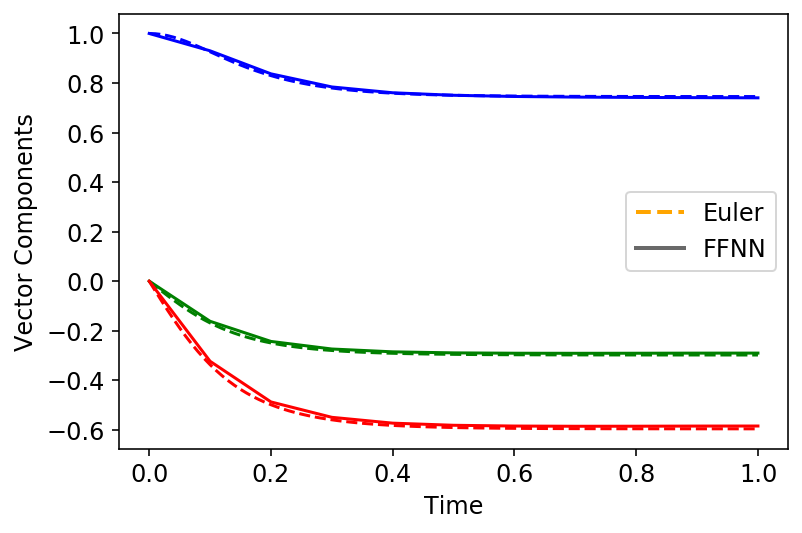

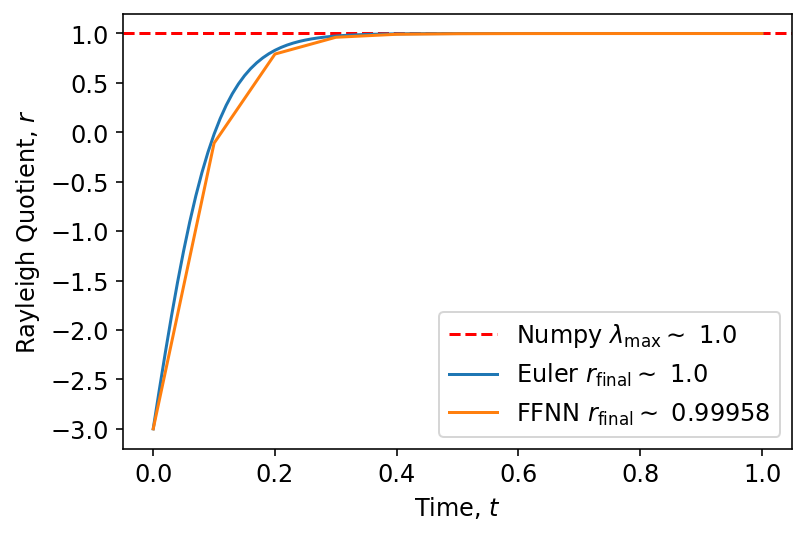

In [19]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
                              x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time
N = 101  # number of time points

# Benchmark problem, 3x3 matrix
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
A = -A
x0 = np.array([1, 0, 0])
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
custom_lines = [Line2D([0], [0], color='orange', ls='--', lw=2),
                Line2D([0], [0], color='dimgrey', lw=2)]
ax0.plot(t, x_euler[:, 0], color='b', ls='--')
ax0.plot(t, x_euler[:, 1], color='g', ls='--')
ax0.plot(t, x_euler[:, 2], color='r', ls='--')
ax0.plot(t_tf, g[:, 0], color='b')
ax0.plot(t_tf, g[:, 1], color='g')
ax0.plot(t_tf, g[:, 2], color='r')
ax0.set_ylabel('Vector Components')
ax0.set_xlabel('Time')
ax0.legend(custom_lines, ['Euler', 'FFNN'])
fig0.savefig(fig_path("eigvec_comp_benchrun2.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_benchrun2.pdf"), bbox_inches='tight')
plt.show()

## 6x6

Step: 1, Loss: 1.3945865218491944
Step: 100, Loss: 0.0007279225967363047
Step: 200, Loss: 0.0006284139732119893
Step: 300, Loss: 0.0005410325438126893
Step: 400, Loss: 0.000451086693803897
Step: 500, Loss: 0.00036296653111325157
Step: 600, Loss: 0.0002858169541915603
Step: 700, Loss: 0.00023247953812181933
Step: 800, Loss: 0.0001987743846918519
Step: 900, Loss: 0.00017289531441413931
Step: 1000, Loss: 0.00014914115256009353
Step: 1100, Loss: 0.00012600464846668972
Step: 1200, Loss: 0.00010454943926970621
Step: 1300, Loss: 8.668440256243457e-05
Step: 1400, Loss: 7.258627843845191e-05
Step: 1500, Loss: 6.18207796099782e-05
Step: 1600, Loss: 5.380113796153005e-05
Step: 1700, Loss: 4.782215184799137e-05
Step: 1800, Loss: 4.321288778421295e-05
Step: 1900, Loss: 3.9443009365871124e-05
Step: 2000, Loss: 3.615440645401805e-05



A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.19137732 -1.72491783  0.45168062 -1.08191235  0.15037505]
 [ 0.30750289 -0.43487183  0.45168062 -0.2257763   0.22161311 -1.24122956]
 [-0.38926805 -0.17624755 -1.08191235  0.22161311 -0.60063869  0.26542558]
 [-0.41792178  0.69327422  0.15037505 -1.24122956  0.26542558 -1.22084365]]
x0 = [0.09422772 0.15721233 0.16526607 0.05588    0.29309754 0.23431634]
Eigvals Numpy: [-3.13078844  1.82431291  1.21134579 -0.81694732  0.15215664 -1.74810717]
Max Eigval Numpy 1.8243129103884215
Final Rayleigh Quotient Euler 1.8231808756711405
Final Rayleigh Quotient FFNN 1.8162078906887706


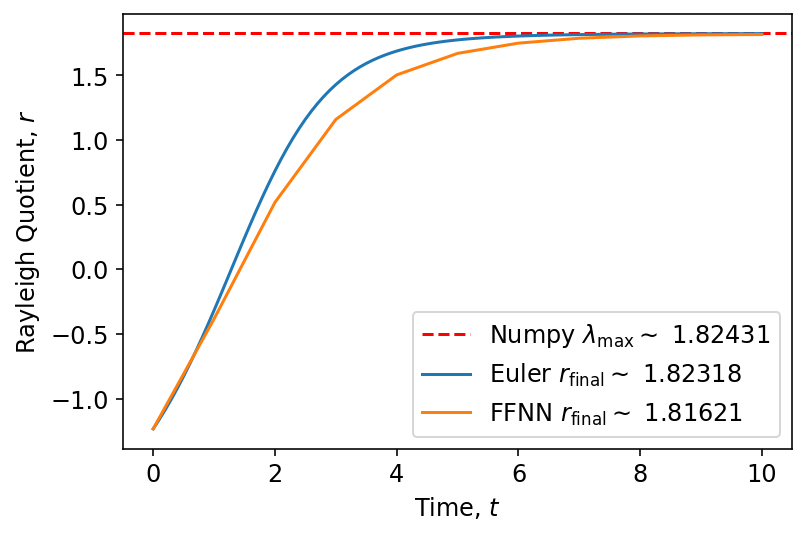

In [20]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    #A = tf.cast(A, tf.float32)
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))
    #return tf.losses.MSE(tf.zeros_like(d_trial_dt), d_trial_dt - rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        #x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
                               x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
n = 6    # Dimension
T = 10   # Final time
N = 101  # number of time points

# Benchmark problem
np.random.seed(42)
tf.random.set_seed(42)
A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0, ord=1)
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66a.pdf"), bbox_inches='tight')
plt.show()